# Making LOCA geodatabase

In [26]:
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point
from time import time

import rioxarray  # for the extension to load
import rasterio

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

crs = "EPSG:3310" # CA equal Albers CRS

In [42]:
# Load census tract shapefile or GeoJSON
census_tracts = gpd.read_file(
    "CA_tiger_2023_tract/"
)  # GeoDataFrame of census tracts for LA County

### we want to convert the census tract polygons from lon-lat coordinates
### to x-y coordinates like we have for our WRF output.
### this is because sjoin_nearest() can better calculate the distances
### between grid points and polygons when we use an area-preserving projection,
### which WRF natively uses.

# subset geodataframe to the minimum of what we need
# so we save memory
census_tracts = census_tracts[["geometry", "GEOID"]]
census_tracts = census_tracts.to_crs(crs)
display(census_tracts)

,geometry,GEOID
0,"POLYGON ((-177981.55 -51137.614, -177979.26 -5...",06001442700
1,"POLYGON ((-176688.486 -52219.888, -176682.583 ...",06001442800
2,"POLYGON ((165979.248 -442413.375, 165979.82 -4...",06037204920
3,"POLYGON ((164414.225 -441707.563, 164427.648 -...",06037205110
4,"POLYGON ((143676.272 -411800.427, 143812.312 -...",06037320101
...,...,...
9124,"POLYGON ((188706.771 -452501.282, 188733.86 -4...",06059001303
9125,"POLYGON ((188697.755 -452099.655, 188778.369 -...",06059001304
9126,"POLYGON ((189454.205 -450215.987, 189454.373 -...",06059001401
9127,"POLYGON ((-205775.612 -3326.14, -205774.55 -33...",06013367200


In [43]:
census_tracts.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [44]:
# get LOCA data - we just need the grid information from it so we take one time step
above_90 = xr.open_dataset("avg_extreme_heat_days_above_98th_percentile.nc", engine="netcdf4")
ds = above_90.sel(time_slice_name="mid-century")


# we want to load the dataset into memory here; it will make future computations much faster
ds = ds.compute()
display(ds)

<xarray.Dataset> Size: 800kB
Dimensions:                                               (lat: 303, lon: 329)
Coordinates:
    time_slice_name                                       <U11 44B 'mid-century'
  * lat                                                   (lat) float32 1kB 3...
  * lon                                                   (lon) float32 1kB -...
    scenario                                              <U18 72B 'Historica...
    spatial_ref                                           int64 8B 0
    quantile                                              float64 8B 0.98
    time_slice_range                                      <U9 36B '2035–2064'
Data variables:
    avg annual # extreme heat days above 98th percentile  (lat, lon) float64 797kB ...

In [45]:
# convert LOCA 
# from lat-lon grid to geographic projection

ds.rio.write_crs('EPSG:4326', inplace=True) # EPSG for LOCA2: https://analytics.cal-adapt.org/data/access/
ds = ds.rio.set_spatial_dims(x_dim="lon",y_dim="lat")
ds_xy = ds.rio.reproject(crs) # reproject to CA equal albers
display(ds_xy)

<xarray.Dataset> Size: 859kB
Dimensions:                                               (x: 311, y: 343)
Coordinates:
  * x                                                     (x) float64 2kB -4....
  * y                                                     (y) float64 3kB 4.5...
    time_slice_name                                       <U11 44B 'mid-century'
    quantile                                              float64 8B 0.98
    scenario                                              <U18 72B 'Historica...
    time_slice_range                                      <U9 36B '2035–2064'
    spatial_ref                                           int64 8B 0
Data variables:
    avg annual # extreme heat days above 98th percentile  (y, x) float64 853kB ...

In [46]:
ds.crs

AttributeError: 'Dataset' object has no attribute 'crs'

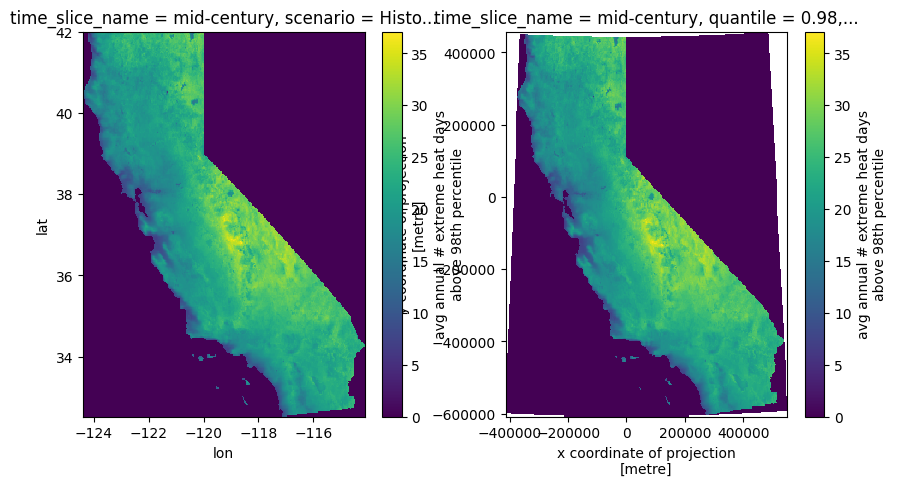

In [47]:
# compare the projections
name = "avg annual # extreme heat days above 98th percentile"

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ds[name].plot(ax=ax[0])
ds_xy[name].plot(ax=ax[1])

In [48]:
# convert to geodataframe and spatially join
df = ds_xy.squeeze().to_dataframe().reset_index().set_index("time_slice_name")
gdf = gpd.GeoDataFrame(data=df, geometry=gpd.points_from_xy(df.x, df.y)).set_crs(
    crs
)
# save the original WRF grid points to the geodataframe
gdf[["x", "y"]] = gdf.apply(
    lambda p: (p.geometry.x, p.geometry.y), axis=1, result_type="expand"
)
# spatially join the gridded LOCA data to the census tract polygons
mapped_tracts = census_tracts.sjoin_nearest(gdf, how="left")
# subset to the columns we care about
mapped_tracts = mapped_tracts[["GEOID", "x", "y", "geometry"]]

In [50]:
gdf.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [51]:
census_tracts.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [52]:
mapped_tracts.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [32]:
gdf['geometry']

time_slice_name
mid-century    POINT (-412932.82 455981.566)
mid-century    POINT (-412932.82 452875.287)
mid-century    POINT (-412932.82 449769.008)
mid-century    POINT (-412932.82 446662.729)
mid-century     POINT (-412932.82 443556.45)
                           ...              
mid-century    POINT (550013.73 -593940.801)
mid-century    POINT (550013.73 -597047.081)
mid-century     POINT (550013.73 -600153.36)
mid-century    POINT (550013.73 -603259.639)
mid-century    POINT (550013.73 -606365.918)
Name: geometry, Length: 106673, dtype: geometry

In [53]:
# set the geometry to the original LOCA x-y grid points
mapped_tracts = mapped_tracts.set_geometry(
    gpd.points_from_xy(mapped_tracts.x, mapped_tracts.y)
)[["GEOID", "geometry"]]
display(mapped_tracts)

,GEOID,geometry
0,06001442700,POINT (-176855.602 -50341.942)
1,06001442800,POINT (-176855.602 -53448.222)
2,06037204920,POINT (167941.389 -441733.121)
3,06037205110,POINT (164835.11 -441733.121)
4,06037320101,POINT (143091.155 -410670.329)
...,...,...
9124,06059001303,POINT (189685.343 -454158.238)
9125,06059001304,POINT (189685.343 -454158.238)
9126,06059001401,POINT (189685.343 -451051.958)
9127,06013367200,POINT (-204812.114 -3747.754)


In [54]:
mapped_tracts.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

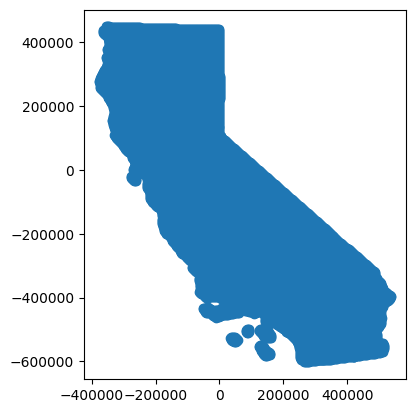

In [34]:
mapped_tracts.plot()

,GEOID,geometry
0,06001442700,POINT (-122.00465 37.54669)
1,06001442800,POINT (-122.0039 37.51876)
2,06037204920,POINT (-118.18146 34.02545)
3,06037205110,POINT (-118.21508 34.02598)
4,06037320101,POINT (-118.44498 34.30938)
...,...,...
9124,06059001303,POINT (-117.94898 33.90945)
9125,06059001304,POINT (-117.94898 33.90945)
9126,06059001401,POINT (-117.94826 33.93745)
9127,06013367200,POINT (-122.33441 37.95997)


<Axes: >

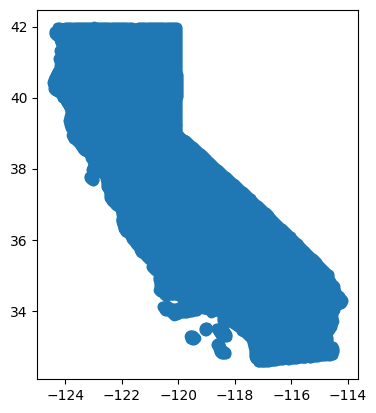

In [55]:
# finally, convert back to the original LOCA projection
mapped_tracts.to_crs('EPSG:4326', inplace=True)
display(mapped_tracts)
mapped_tracts.plot()

In [36]:
mapped_tracts.to_file("loca_points_to_geoid.gdb")

In [56]:
mapped_tracts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Check results

In [37]:
gdb = gpd.read_file("loca_points_to_geoid.gdb")

In [39]:
gdb

,GEOID,geometry
0,06001442700,POINT (-122.00465 37.54669)
1,06001442800,POINT (-122.0039 37.51876)
2,06037204920,POINT (-118.18146 34.02545)
3,06037205110,POINT (-118.21508 34.02598)
4,06037320101,POINT (-118.44498 34.30938)
...,...,...
50013,06059001303,POINT (-117.94898 33.90945)
50014,06059001304,POINT (-117.94898 33.90945)
50015,06059001401,POINT (-117.94826 33.93745)
50016,06013367200,POINT (-122.33441 37.95997)
